In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pyrealsense2 as rs
import os
import numpy as np
import sys
import scipy
import random
import math
import skimage.io
import datetime
import open3d as o3d

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
#sys.path.append(os.path.join(ROOT_DIR, "samples/balloon/"))  # To find local version
Stones_DIR = os.path.join(ROOT_DIR, "datasets/stones")

import coco

#from samples.blister import blister_mul_class
import stones

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
STONES_MODEL_PATH = "../../logs/stones20190614T1000/mask_rcnn_stones_0100.h5"

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

from poke_grasp.msg import stone_pose
import rospy
import geometry_msgs.msg
import time
import actionlib
from std_msgs.msg import String

Using TensorFlow backend.


In [2]:
rospy.init_node('stone_segmentation')

In [3]:
def make_directories():
    if not os.path.exists("JPEGImages/"):
        os.makedirs("JPEGImages/")
    if not os.path.exists("depth/"):
        os.makedirs("depth/")

In [4]:
def image_process(img_index):
    make_directories()

    # Setup:
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
    config.enable_record_to_file('frames/0.bag')
    profile = pipeline.start(config)

    # Skip 5 first frames to give the Auto-Exposure time to adjust
    for x in range(10):
        pipeline.wait_for_frames()
    # Store next frameset for later processing:
    frames = pipeline.wait_for_frames()
    color_frame = frames.get_color_frame()
    depth_frame = frames.get_depth_frame()

    # Cleanup:
    pipeline.stop()
    print("Frames Captured")
    
    color = np.asanyarray(color_frame.get_data())
    # Visualization
    #plt.rcParams["axes.grid"] = False
    #plt.rcParams['figure.figsize'] = [12, 6]
    #plt.imshow(color)
    
    colorizer = rs.colorizer()
    colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
    # Visualization
    #plt.imshow(colorized_depth)
    
    # Create alignment primitive with color as its target stream:
    align = rs.align(rs.stream.color)
    frames = align.process(frames)

    # Update color and depth frames:
    aligned_depth_frame = frames.get_depth_frame()
    #print(aligned_depth_frame)
    colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

    #print(aligned_depth_frame.get_distance(532,36))
    
    # Show the two frames together:
    images = np.hstack((color, colorized_depth))
    plt.imshow(images)

    filecolor= "JPEGImages/"+img_index+".jpg"
    filedepth= "depth/"+img_index+".png"
    cv2.imwrite(filecolor, color)
    cv2.imwrite(filedepth, colorized_depth)
    
    return colorized_depth, aligned_depth_frame

In [5]:
# Start instance segmentation by Mask RCNN
class InferenceConfig(stones.StonesConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
##config.display()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(STONES_MODEL_PATH, by_name=True)

# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = stones.StonesDataset()
dataset.load_stones(Stones_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
    
class_names = dataset.class_names

Re-starting from epoch 100
Image Count: 101
Class Count: 2


In [6]:
#print(color.shape)
#print(r['masks'].shape)
#print(r['scores'])

'''
color_copy = color.copy()
cv2.circle(color_copy,(350,120), 5, (0,0,0), 5)
cv2.circle(color_copy,(200,100), 5, (0,0,0), 5)
plt.imshow(color_copy)

print(aligned_depth_frame.get_distance(350,120))
print(aligned_depth_frame.get_distance(200,100))
'''

'\ncolor_copy = color.copy()\ncv2.circle(color_copy,(350,120), 5, (0,0,0), 5)\ncv2.circle(color_copy,(200,100), 5, (0,0,0), 5)\nplt.imshow(color_copy)\n\nprint(aligned_depth_frame.get_distance(350,120))\nprint(aligned_depth_frame.get_distance(200,100))\n'

In [7]:
def pixel_to_camera(pixel, intrin, depth):
    #depth = depth #/ 1000
    X = (pixel[0]-intrin[0]) * depth / intrin[2]
    Y = (pixel[1]-intrin[1]) * depth / intrin[3]
    return [X, Y]

In [8]:
# Compute position of mask center and rotation of mask
def get_mask_pose(depth_intrin, depth_array, m_c, mm_pair, max_d, min_d, surf_normal):
    #position = m_c
    print('select mask center', m_c)
    m_c_dist = depth_array[m_c[1], m_c[0]]/1000
    #position = rs.rs2_deproject_pixel_to_point(depth_intrin, m_c, m_c_dist)
    position = pixel_to_camera(m_c, depth_intrin, m_c_dist)
    min2max_vec = [mm_pair[0][0]-mm_pair[1][0], mm_pair[0][1]-mm_pair[1][1]]
    yaw = math.atan2(min2max_vec[1], min2max_vec[0])
    print('test min2max_vec and yaw', min2max_vec, yaw)
    pitch = math.atan2(max_d-min_d, 0.023)
    if min2max_vec[0] > 0:
        yaw = math.pi/2 + yaw
    elif min2max_vec[0] < 0:
        if min2max_vec[1] > 0:
            yaw = -(3*math.pi/2-yaw)
        elif min2max_vec[1] < 0:
            yaw = -(-yaw-math.pi/2)
        
    #if yaw > 0:
    #    if mm_pair[0][0] > mm_pair[1][0]:
    #        yaw = math.pi - yaw
    #else:
    #    if mm_pair[0][0] < mm_pair[1][0]:
    #        yaw = math.pi + yaw
    if surf_normal == []:
        print("surf normal empty")
        pose={
            'x':position[0],
            'y':position[1],
            'z':m_c_dist,
            'yaw':yaw,
            'pitch':pitch,
            'normal':surf_normal
        }
    else:
        pose={
            'x':position[0],
            'y':position[1],
            'z':m_c_dist,
            'yaw':yaw,
            'pitch':pitch,
            'normal':surf_normal
        }
    return pose

In [14]:
def sortFourth(val): 
    return val[3]  

def generate_stone_pose(depth_image, depth_array, seg_result):
    depth_copy = depth_image.copy()
    mask_size = []
    mask_store = 4
    window = 10

    # Rank masks by footprints
    for m in range(seg_result['masks'].shape[2]):
        mask = seg_result['masks'][:,:,m]
        #print(mask.shape)
        mask = mask.astype(np.uint8)
        mask_size.append(np.sum(mask))
    mask_index = np.argsort(np.array(mask_size))[-mask_store:seg_result['masks'].shape[2]]

    mask_center = []
    max_min_pair = []
    dist_min = []
    dist_max = []
    count_m = 0
    points = []
    point_show = []
    points_ero = []
    point_show_ero = []
    kernel = np.ones((15,15),np.uint8)
    '''
    image_center = [depth_copy.shape[1]/2, depth_copy.shape[0]/2]

    for m in range(seg_result['masks'].shape[2]):
        overall_mask_x = []
        overall_mask_y = []
        
        mask = seg_result['masks'][:,:,m]
        mask = mask.astype(np.uint8)
        edges = cv2.Canny(mask,0,1)
        for i in range(depth_copy.shape[0]): #480
            for j in range(depth_copy.shape[1]): #640
                if edges[i,j] == 255:
                    overall_mask_x.append(j) #in pixel
                    overall_mask_y.append(i) #in pixel
        mask_center.append([int(round(np.mean(overall_mask_x))), int(round(np.mean(overall_mask_y))), m]) #in pixel frame
        print('mask center', mask_center[m][:2])
        mask_center[m].append(np.linalg.norm(np.array(mask_center[m][:2])-np.array(image_center)))
    mask_center.sort(key=sortFourth)
    '''
    #print(np.argsort(np.array(mask_size)))
    #print(np.argsort(np.array(mask_size))[-3:r['masks'].shape[2]])
    
    for m in mask_index:
#    for m in range(seg_result['masks'].shape[2]):
        mask = seg_result['masks'][:,:,m]
        mask = mask.astype(np.uint8)
    #    result = colorized_depth.copy()
    #    result[mask!=0] = (0,0,255)

        # Detect edge for each mask
        edges = cv2.Canny(mask,0,1)
    #        plt.figure()
    #        plt.subplot(121),plt.imshow(mask, cmap = 'gray')
    #        plt.subplot(122),plt.imshow(edges, cmap = 'gray')
        #plt.imshow(edges)
        #print("edge shape", edges.shape)

        distance = []
        edge_point = []
        min_candidate = []
        max_candidate = []
        count = 0
        dist_max_ = -100000
        max_index = [0, 0]
        dist_min_ = 100000
        min_index = [0, 0]
        depth_intrin = [321.8862609863281, 238.18316650390625, 612.0938720703125, 611.785888671875] # cx, cy, fx, fy
        #print(depth_intrin)
        overall_mask_x = []
        overall_mask_y = []
        point = [] # store pointcloud of each go stone
        point_ero = [] # store pointcloud of each eroded go stone
        erosion = cv2.erode(mask,kernel,iterations = 3)
        
        for i in range(depth_copy.shape[0]): #480
            for j in range(depth_copy.shape[1]): #640
                if edges[i,j] == 255:
                #if mask[i, j] == 1:
                    overall_mask_x.append(j) #in pixel
                    overall_mask_y.append(i) #in pixel
                    depth_copy[i,j] = [0, 255, 0]
                    edge_point.append([j, i]) #in pixel frame

                    if depth_array[i,j]/1000 > dist_max_ and depth_array[i,j]/1000 != 0:
                        dist_max_ = depth_array[i,j]/1000
                        #print("dist_max", dist_max)
                        max_index = [j, i] #in pixel frame

                    if depth_array[i,j]/1000 < dist_min_ and depth_array[i,j]/1000 != 0:
                        dist_min_ = depth_array[i,j]/1000
                        #print("dist_min", dist_min)
                        min_index = [j, i] #in pixel frame

                    count = count + 1
                if mask[i,j] == 1:
                    xy = pixel_to_camera([j, i], depth_intrin, depth_array[i, j])
                    point.append([xy[0], xy[1], depth_array[i, j]]) # add pointcloud
                if erosion[i, j] == 1:
                    xy = pixel_to_camera([j, i], depth_intrin, depth_array[i, j])
                    point_ero.append([xy[0], xy[1], depth_array[i, j]]) # add pointcloud eroded
                    
        point_show = point_show + point # pointcloud for all go stone candidates
        points.append(point)
        point_show_ero = point_show_ero + point_ero # pointcloud for all eroded go stone candidates
        points_ero.append(point_ero)
        
        #print('another dist max min', dist_max_, dist_min_)
        cv2.circle(depth_copy,tuple(edge_point[0]), 5, (0,0,255), 2)
        '''
        print(len(edge_point))
        avg = np.zeros(len(edge_point))
        for i in range(len(edge_point)):
            for j in range(window):
                #print(i+j+len(edge_point)%len(edge_point))
                edge_px = edge_point[(i+j+len(edge_point))%len(edge_point)]
                avg[i] += depth_array[edge_px[1], edge_px[0]]/1000
        avg = avg / window
        print('avg', avg)
        sorted_avg_idx = avg.argsort()
        dist_min.append(avg[sorted_avg_idx[0]])
        dist_max.append(avg[sorted_avg_idx[len(sorted_avg_idx)-1]])
        print('dist_max',dist_max[count_m], 'dist_min',dist_min[count_m])
        #print('sorted_avg_idx', sorted_avg_idx)sorted_avg_idx[len(sorted_avg_idx)-1]+int(window/2)
        print('index', sorted_avg_idx[0]+int(window/2), sorted_avg_idx[len(sorted_avg_idx)-1]+int(window/2))
        dist_min_px = edge_point[(sorted_avg_idx[0]+int(window/2)+len(edge_point))%len(edge_point)]
        dist_max_px = edge_point[(sorted_avg_idx[len(sorted_avg_idx)-1]+int(window/2)+len(edge_point))%len(edge_point)]
        max_min_pair.append([dist_max_px, dist_min_px])
        print('max_min', max_min_pair[count_m])
        '''
        max_min_pair.append([max_index, min_index])
        dist_max.append(dist_max_)
        dist_min.append(dist_min_)
        
        #    print("max_index", max_index)
        #    print("min_index", min_index)


        #    print(int(round(np.mean(overall_mask_x))))
        #    print(int(round(np.mean(overall_mask_y))))
        mask_center.append([int(round(np.mean(overall_mask_x))), int(round(np.mean(overall_mask_y))), count_m]) #in pixel frame
        print('mask center', mask_center[count_m][:2])
        '''
        maxp2cp_vec = np.array(max_index) - np.array(mask_center[count_m][:2])
        minp2cp_vec = np.array(min_index) - np.array(mask_center[count_m][:2])
        dth_maxp_min = 10000
        dth_minp_min = 10000
        for i in range(len(edge_point)):
            cp2fakep_vec = np.array(mask_center[count_m][:2]) - np.array(edge_point[i])
            #print(np.matmul(maxp2cp_vec,cp2fakep_vec) / (np.linalg.norm(maxp2cp_vec)*np.linalg.norm(cp2fakep_vec)))
            dth_maxp = np.arccos(np.matmul(maxp2cp_vec,cp2fakep_vec) / (np.linalg.norm(maxp2cp_vec)*np.linalg.norm(cp2fakep_vec)))
            if  dth_maxp < dth_maxp_min:
                dth_maxp_min = dth_maxp
                min_candidate = edge_point[i] #in pixel frame
            #print(np.matmul(minp2cp_vec,cp2fakep_vec) / (np.linalg.norm(minp2cp_vec)*np.linalg.norm(cp2fakep_vec)))
            dth_minp = np.arccos(np.matmul(minp2cp_vec,cp2fakep_vec) / (np.linalg.norm(minp2cp_vec)*np.linalg.norm(cp2fakep_vec)))
            if dth_minp < dth_minp_min:
                dth_minp_min = dth_minp
                max_candidate = edge_point[i] #in pixel frame
        #    print("min_candidate", min_candidate)
        #    print("max_candidate", max_candidate)
        max_dist_gap = depth_array[max_candidate[1],max_candidate[0]]/1000 \
        -depth_array[max_index[1],max_index[0]]/1000
        print('max_dist_gap', max_dist_gap)
        min_dist_gap = depth_array[min_candidate[1],min_candidate[0]]/1000 \
        -depth_array[min_index[1],min_index[0]]/1000
        if  max_dist_gap < min_dist_gap:
            max_min_pair.append([max_candidate, min_index]) #in pixel frame
        else:
            max_min_pair.append([max_index, min_candidate]) #in pixel frame
        dist_min.append(depth_array[max_min_pair[count_m][1][1],max_min_pair[count_m][1][0]]/1000)
        dist_max.append(depth_array[max_min_pair[count_m][0][1],max_min_pair[count_m][0][0]]/1000)
        print('dist_max',dist_max[count_m], 'dist_min',dist_min[count_m])
        '''
        cv2.circle(depth_copy,tuple(max_min_pair[count_m][0]), 5, (0,0,0), 2)
        cv2.circle(depth_copy,tuple(max_min_pair[count_m][1]), 5, (255,0,0), 2)
        cv2.circle(depth_copy,tuple(mask_center[count_m][:2]), 5, (255,0,0), 1)
        #print(get_mask_pose(depth_intrin, depth_array, mask_center[count_m], max_min_pair[mask_center[count_m][2]], dist_max[mask_center[count_m][2]], dist_min[mask_center[count_m][2]],[]))
        count_m = count_m + 1
    
    image_center = [depth_copy.shape[1]/2, depth_copy.shape[0]/2]
    for i in range(mask_store):
        #print('norm', mask_center[i][:2], image_center)
        #print('norm', np.linalg.norm(np.array(mask_center[i][:2])-np.array(image_center)))
        mask_center[i].append(np.linalg.norm(np.array(mask_center[i][:2])-np.array(image_center)))
    mask_center.sort(key=sortFourth)
    #cv2.circle(depth_copy,(100,200), 5, (0,0,0), 10)
    plt.figure()
    plt.rcParams['figure.figsize'] = [24, 12]
    plt.imshow(depth_copy)
    
    # Generate surface normal
    pcd_ero = o3d.geometry.PointCloud()
    pcd_ero.points = o3d.utility.Vector3dVector(points_ero[mask_center[0][2]])
    pcd_temp = o3d.geometry.PointCloud()
    pcd_temp.points = o3d.utility.Vector3dVector(point_show_ero)
    #pcd_temp.points = o3d.utility.Vector3dVector(points[mask_center[0][2]])
    o3d.io.write_point_cloud("test_ros_ero.ply", pcd_temp)
    o3d.io.write_point_cloud("test_ros_ero_selected.ply", pcd_ero)
    downpcd = o3d.geometry.voxel_down_sample(pcd_ero, voxel_size=1)
    #print("Recompute the normal of the downsampled point cloud")
    o3d.geometry.estimate_normals(downpcd, search_param=o3d.geometry.KDTreeSearchParamHybrid(
        radius=10, max_nn=30))
    print("Normal as a numpy array")
    
    for i in range(np.asarray(downpcd.normals).shape[0]):
        if downpcd.normals[i][2] > 0:
            downpcd.normals[i][0] = -downpcd.normals[i][0]
            downpcd.normals[i][1] = -downpcd.normals[i][1]
            downpcd.normals[i][2] = -downpcd.normals[i][2]
    
    normals = np.asarray(downpcd.normals)
    surf_normal = np.sum(normals, axis=0) / normals.shape[0]
    
    return get_mask_pose(depth_intrin, depth_array, mask_center[0], max_min_pair[mask_center[0][2]], dist_max[mask_center[0][2]], dist_min[mask_center[0][2]], surf_normal), depth_copy

/home/zhekai/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/zhekai/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  216.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   88.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
mask center [302, 332]
mask center [320, 90]
mask center [443, 225]
mask center [273, 151]
Normal as a numpy array
select mask center [302, 332, 0, 93.74433316206373]
test min2max_vec and yaw [-27, 70] 1.9389270981200601


/home/zhekai/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


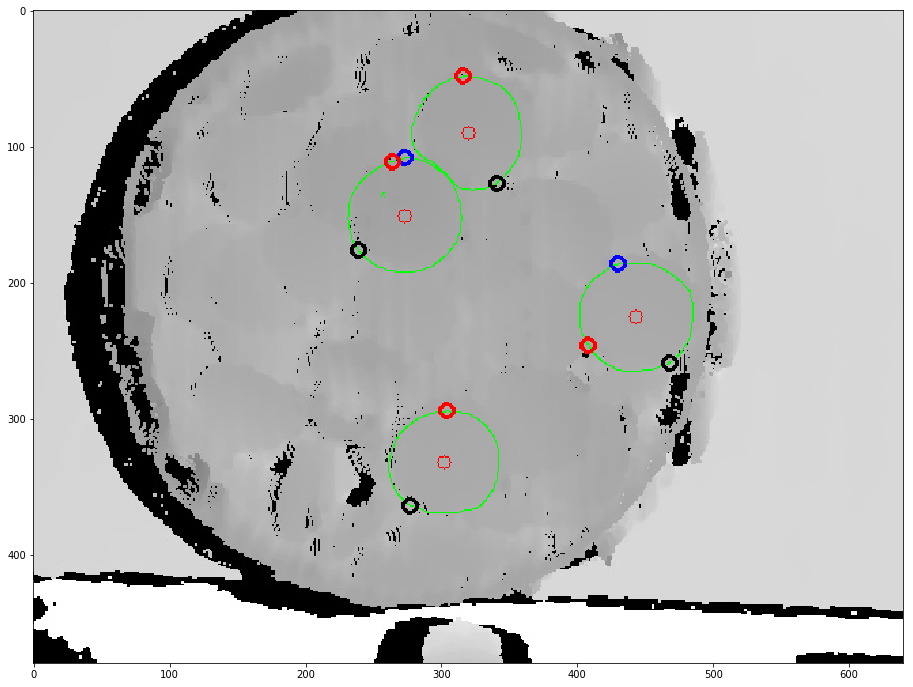

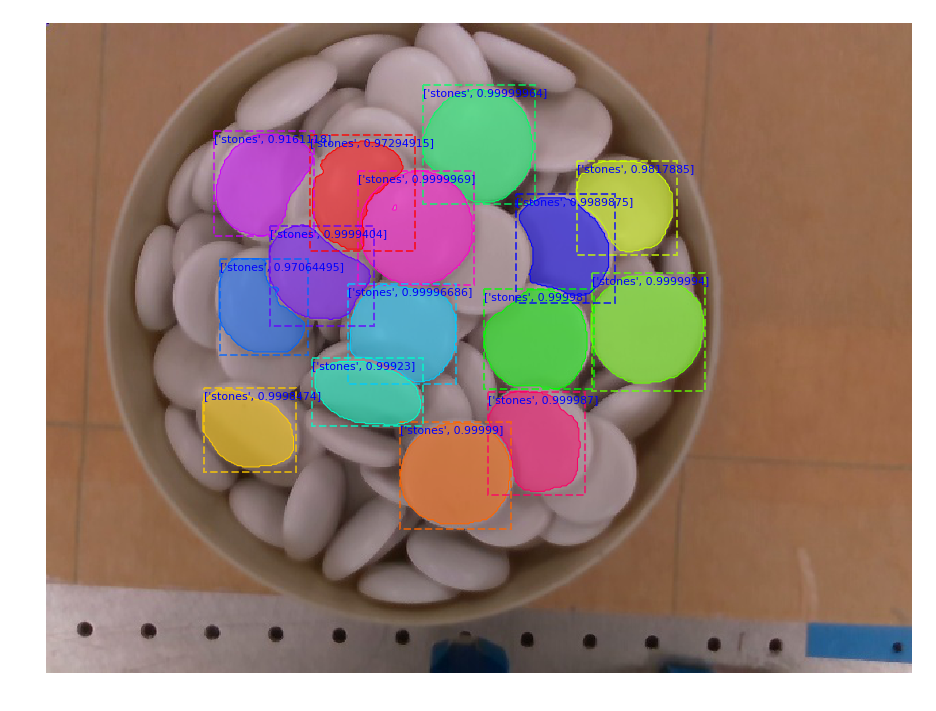

In [15]:
'''
image = scipy.misc.imread("JPEGImages/0.jpeg")
        
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]

#depth_image = cv2.imread("depth/"+img_index+".jpeg")
depth_image = cv2.imread("depth/0.jpeg")
depth_array = np.load("./depth/0.npy")
generate_stone_pose(depth_image, depth_array, r)
#plt.figure()
#plt.rcParams['figure.figsize'] = [24, 12]
#plt.imshow(depth_copy)

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
'''

In [11]:
is_detect = 0
img_index = 0
def img_index_callback(data):
    global img_index
    global is_detect
    
    print(data.data)
    img_index = data.data
    is_detect = 1

In [12]:

rospy.Subscriber('/stone_img_index', String, img_index_callback)

In [13]:
#is_detect = 1

/home/zhekai/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/home/zhekai/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  247.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  116.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
edge shape (480, 640)
another dist max min 0.181 0.164
mask center [263, 184]
select mask center [263, 184, 0]
test min2max_vec and yaw [-60, 55] 2.399645385583876
surf normal empty
{'x': -0.01577755838184319, 'y': -0.014524753628971918, 'z': 0.164, 'yaw': -2.3127435948008137, 'pitch': 0.6365082157879507, 'normal': []}
edge shape (480, 640)
another dist max min 0.172 0.164
mask center [330, 144]
select mask center [330, 144, 1]
test min2max_vec and yaw [39, -44] -0.8455664145524581
surf normal empty
{'x': 0.002226959321919648, 'y': -0.025863250960243427, 'z': 0.168, 'yaw': 0.7252299122424385

/home/zhekai/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


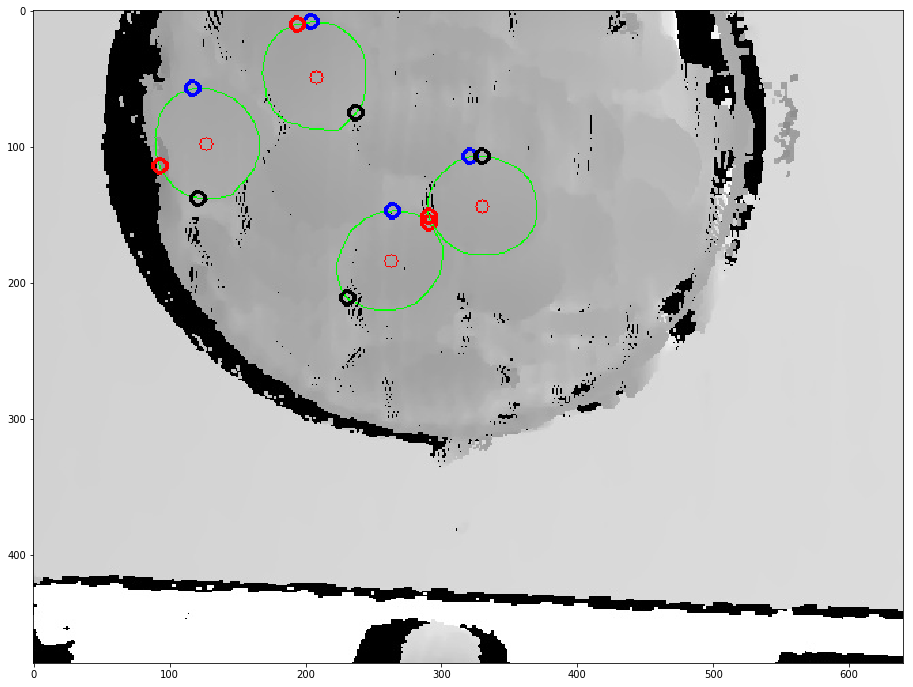

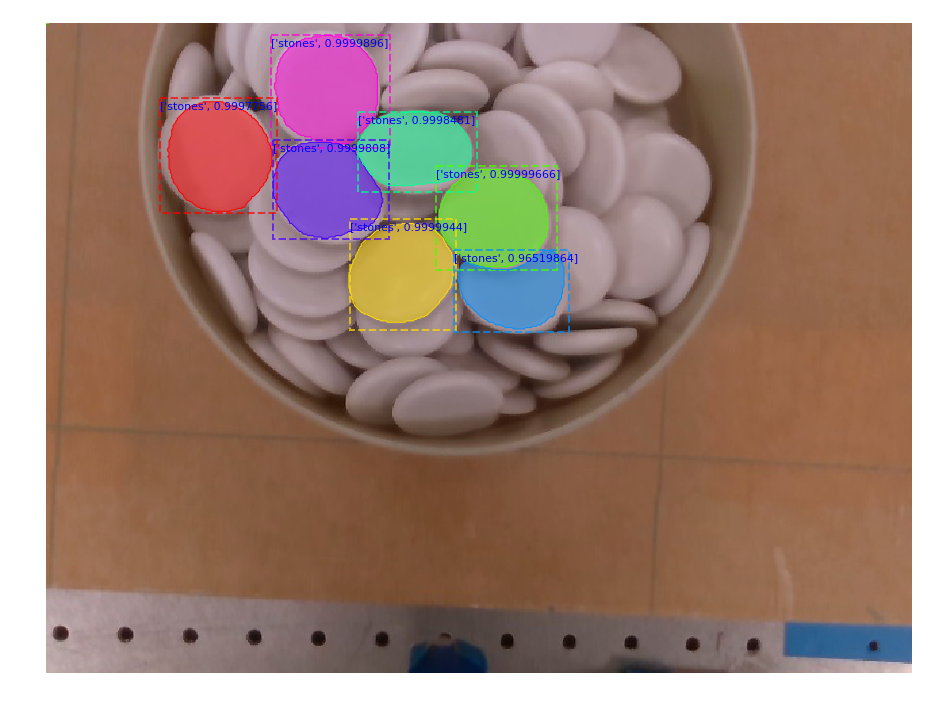

stone_pose_msg is  header: 
  seq: 3
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
x: -0.01577755838184319
y: -0.014524753628971918
z: 0.164
yaw: -2.3127435948008137
pitch: 0.6365082157879507
normal: [-0.52533481 -0.54363577 -0.61903471]
0
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  216.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   88.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
edge shape (480, 640)
another dist max min 0.184 0.169
mask center [302, 332]
select mask center [302, 332, 0]
test min2max_vec and yaw [-27, 70] 1.9389270981200601
surf normal empty
{'x': -0.005523114218152861, 'y': 0.026069352022746548, 'z': 0.17, 'yaw': -2.7734618822646295, 'pitch': 0.5779019369622452, 'normal': []}
edge shape (480, 640)
ano

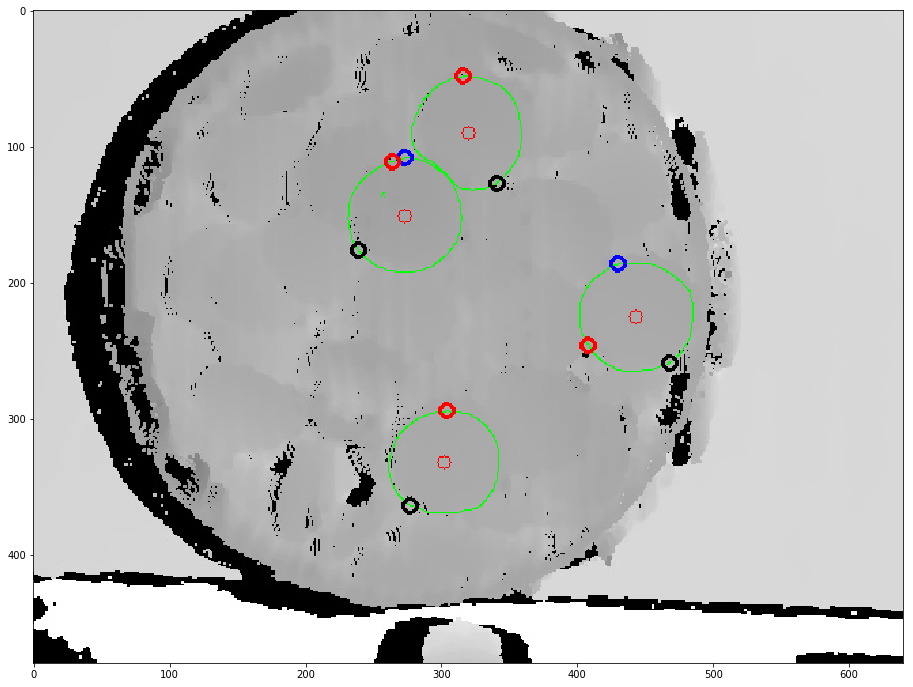

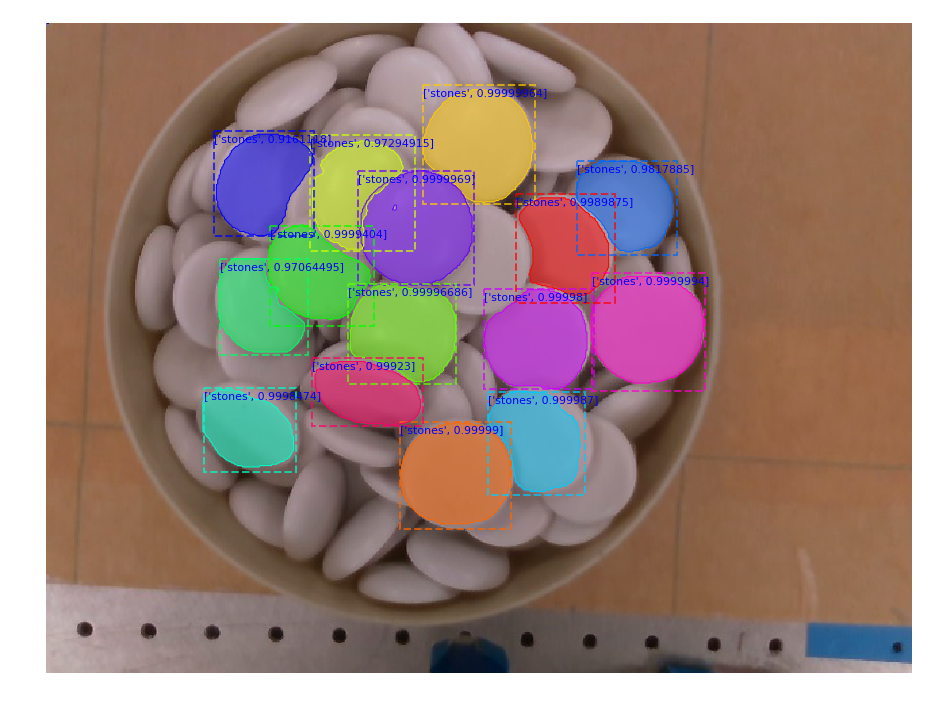

stone_pose_msg is  header: 
  seq: 4
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
x: -0.005523114218152861
y: 0.026069352022746548
z: 0.17
yaw: -2.7734618822646295
pitch: 0.5779019369622452
normal: [-0.01119119 -0.04389417 -0.99869729]
1
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
edge shape (480, 640)
another dist max min 0.182 0.165
mask center [120, 194]
select mask center [120, 194, 0]
test min2max_vec and yaw [11, 73] 1.4212365869211934
surf normal empty
{'x': -0.05508142970077617, 'y': -0.012060737167656009, 'z': 0.167, 'yaw': 2.99203291371609, 'pitch': 0.6365082157879507, 'normal': []}
edge shape (480, 640)
another

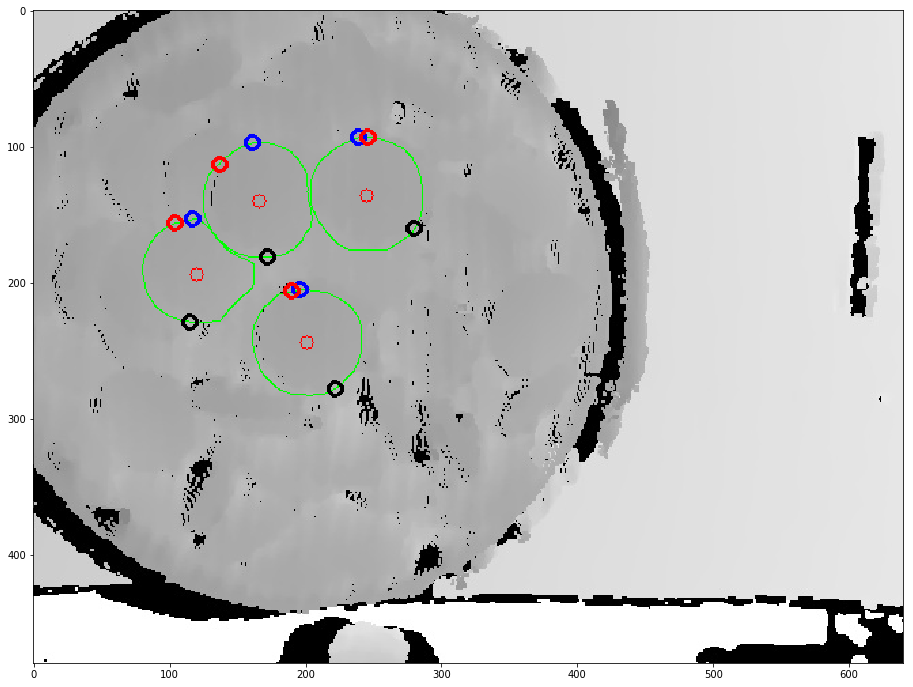

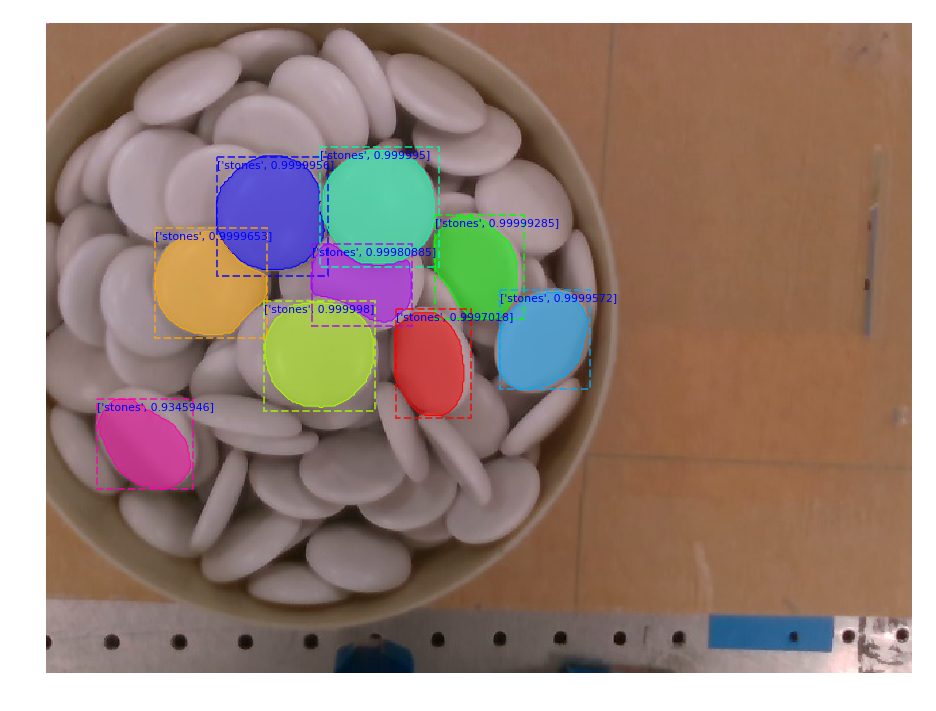

stone_pose_msg is  header: 
  seq: 5
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
x: -0.032784382003133855
y: 0.0015783207462463213
z: 0.166
yaw: 2.723368324010564
pitch: 0.7399748839758711
normal: [ 0.13669065  0.3130999  -0.93531859]
2
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  226.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   99.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
edge shape (480, 640)
another dist max min 0.188 0.161
mask center [472, 231]
select mask center [472, 231, 0]
test min2max_vec and yaw [27, 35] 0.9137213910832431
surf normal empty
{'x': 0.04120137335960766, 'y': -0.001972539731630668, 'z': 0.168, 'yaw': 2.4845177178781395, 'pitch': 0.8652281491096856, 'normal': []}
edge shape (480, 640)
anothe

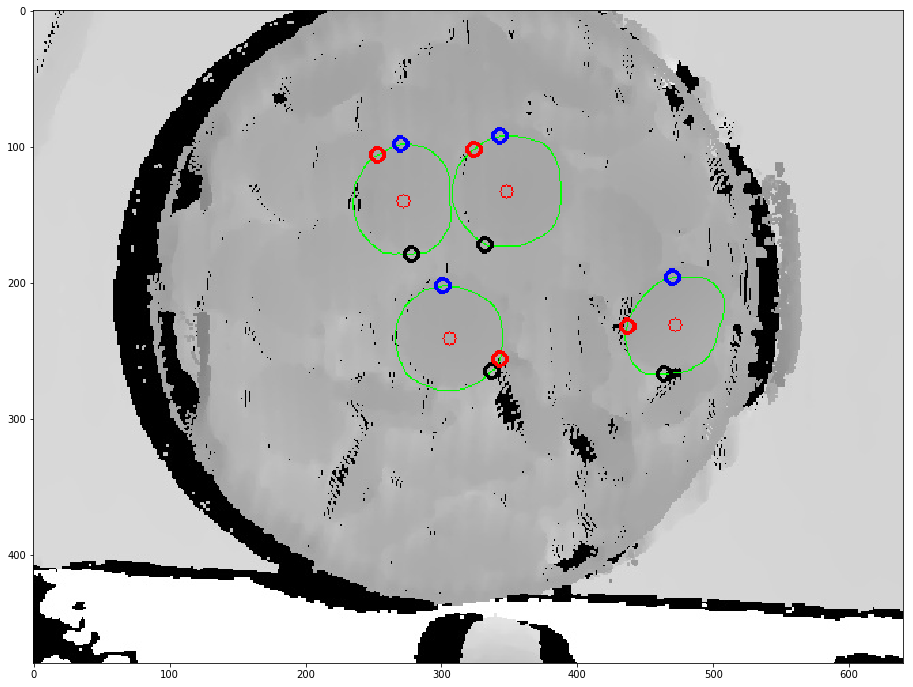

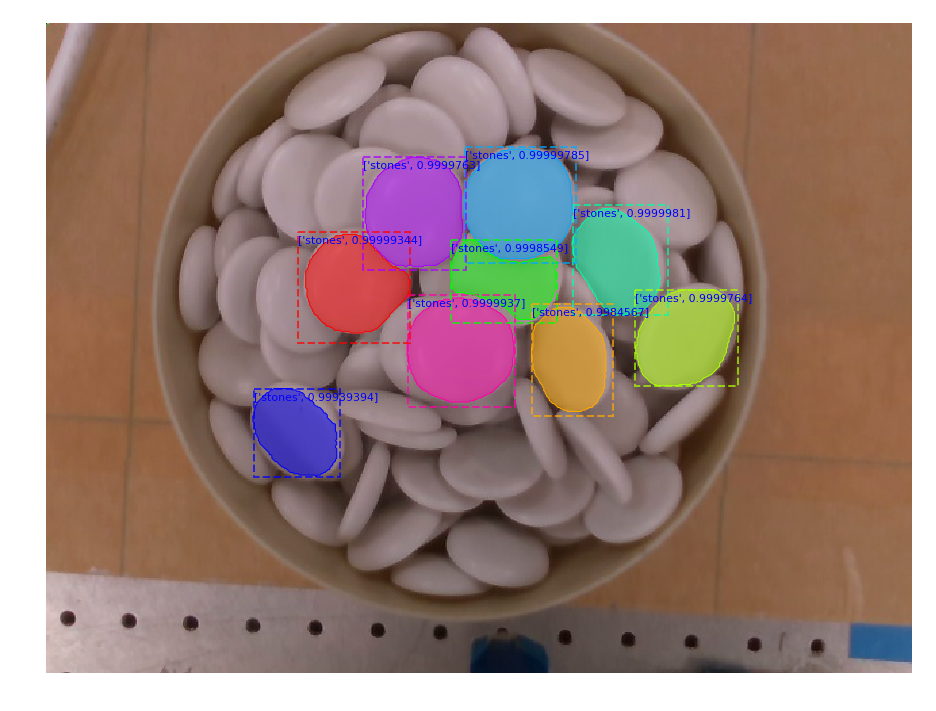

stone_pose_msg is  header: 
  seq: 6
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
x: -0.0043602655858586085
y: 0.0007735190302788447
z: 0.168
yaw: -2.5535900500422257
pitch: 0.6904464570546918
normal: [-0.03095969  0.2768401  -0.95871756]
3
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  204.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   78.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
edge shape (480, 640)
another dist max min 0.182 0.169
mask center [214, 299]
select mask center [214, 299, 0]
test min2max_vec and yaw [26, -3] -0.11487660541689913
surf normal empty
{'x': -0.0299638098085206, 'y': 0.016899477228512996, 'z': 0.17, 'yaw': 1.4559197213779975, 'pitch': 0.5144513130590272, 'normal': []}
edge shape (480, 640)
ano

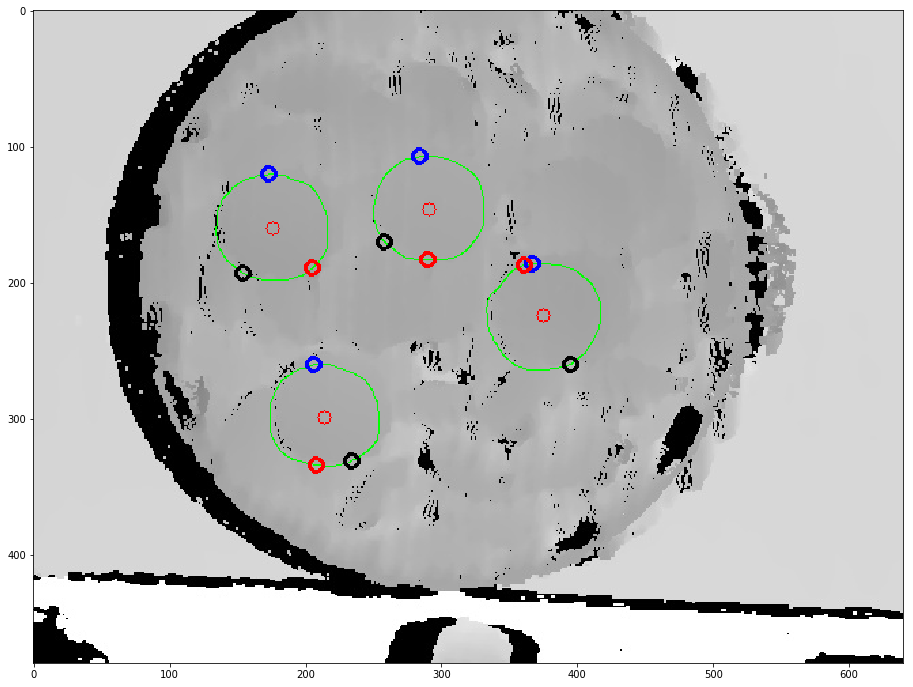

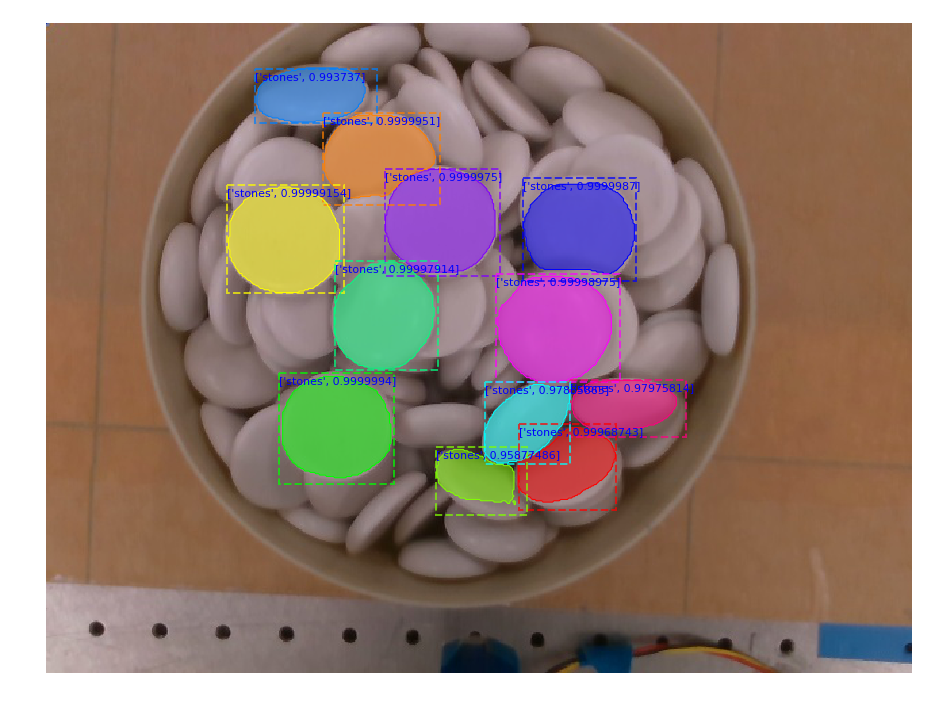

stone_pose_msg is  header: 
  seq: 7
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
x: 0.014317684487860952
y: -0.003825231206664339
z: 0.165
yaw: 2.705715681182408
pitch: 0.7853981633974482
normal: [-0.29945196  0.26154357 -0.9093699 ]
4
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  204.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   80.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
edge shape (480, 640)
another dist max min 0.186 0.166
mask center [377, 154]
select mask center [377, 154, 0]
test min2max_vec and yaw [12, 76] 1.4141944498128813
surf normal empty
{'x': 0.015487106705199337, 'y': -0.02366760153638948, 'z': 0.172, 'yaw': 2.984990776607778, 'pitch': 0.7157435896688799, 'normal': []}
edge shape (480, 640)
another 

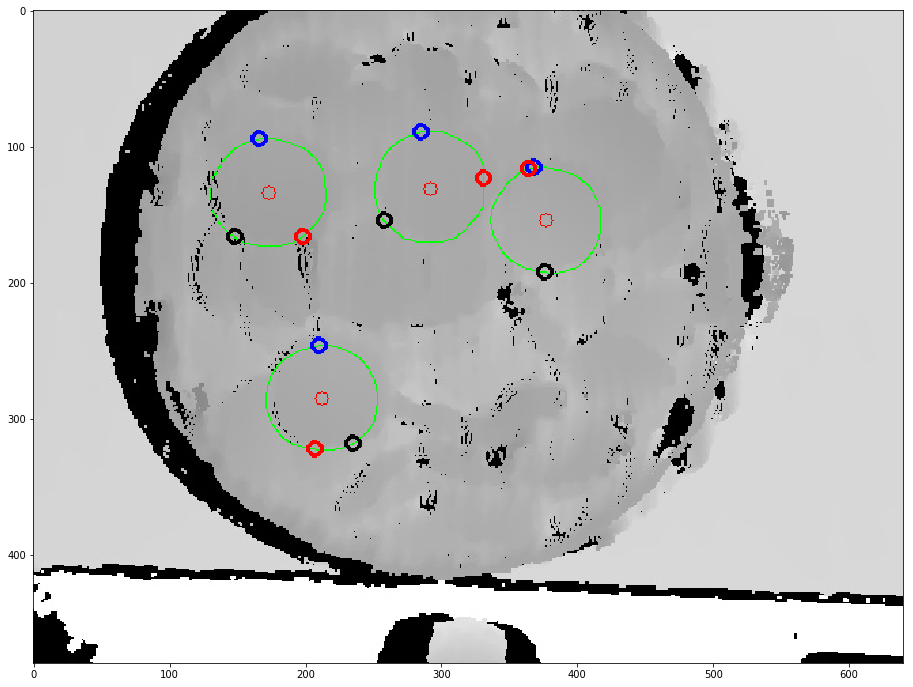

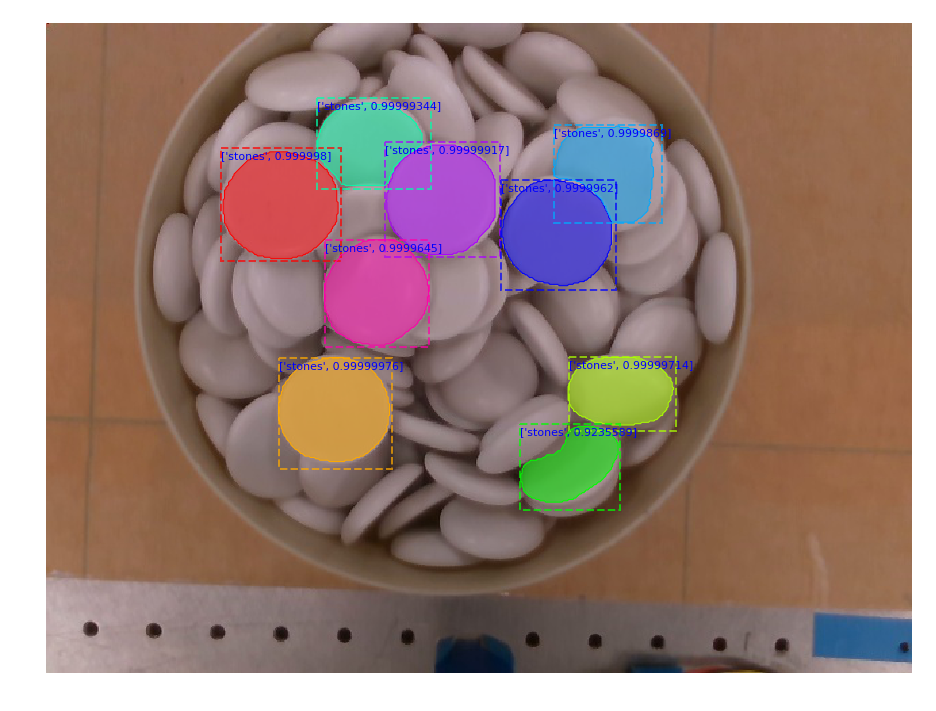

stone_pose_msg is  header: 
  seq: 8
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
x: 0.015487106705199337
y: -0.02366760153638948
z: 0.172
yaw: 2.984990776607778
pitch: 0.7157435896688799
normal: [-0.24672953  0.42059024 -0.83500917]
Traceback (most recent call last):
  File "/home/zhekai/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-31560a83cf05>", line 2, in <module>
    if(is_detect == 1):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zhekai/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1863, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurre

KeyboardInterrupt: 

In [15]:
while (True):
    if(is_detect == 1):
        
        pose_pub = rospy.Publisher('/stone_pose', stone_pose, queue_size=10)
        
        img_index = str(img_index)
              
        
        # instance segmentation
        image = scipy.misc.imread("JPEGImages/"+img_index+".jpeg")
        
        # Run detection
        results = model.detect([image], verbose=1)
        
        # Visualize results
        r = results[0]
        
        #depth_image = cv2.imread("depth/"+img_index+".jpeg")
        depth_image = cv2.imread("depth/"+img_index+".jpeg")
        depth_array = np.load("./depth/"+img_index+".npy")
        pose, depth_copy = generate_stone_pose(depth_image, depth_array, r)
        #plt.figure()
        #plt.rcParams['figure.figsize'] = [24, 12]
        #plt.imshow(depth_copy)
        
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                    class_names, r['scores'])
        
        stone_pose_msg = stone_pose()
        stone_pose_msg.x = pose['x']
        stone_pose_msg.y = pose['y']
        stone_pose_msg.z = pose['z']
        stone_pose_msg.yaw = pose['yaw']
        stone_pose_msg.pitch = pose['pitch']
        stone_pose_msg.normal = pose['normal']

        pose_pub.publish(stone_pose_msg)
        print('stone_pose_msg is ', stone_pose_msg)
        
        is_detect = 0

/home/zhekai/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/zhekai/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Processing 1 images
image                    shape: (480, 640, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  140.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


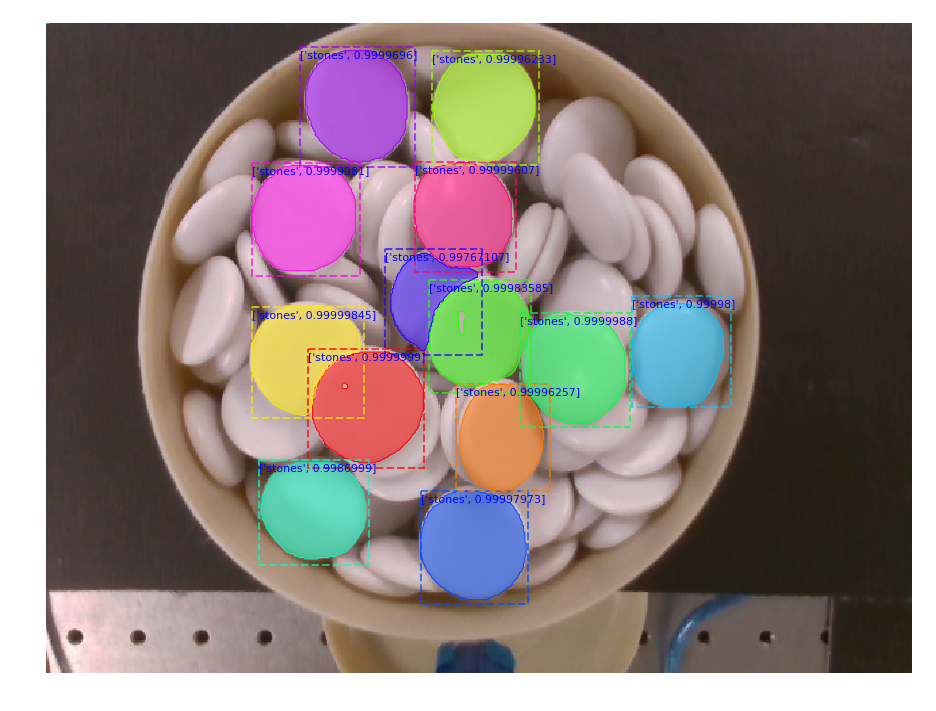

edge shape (480, 640)
another dist max min 0.181 0.162
mask center [390, 255]
select mask center [390, 255, 0]
test min2max_vec and yaw [-26, 75] 1.9044985033324469
surf normal empty
{'x': 0.01869502159136529, 'y': 0.0046180012969521626, 'z': 0.168, 'yaw': -2.8078904770522426, 'pitch': 0.6904464570546918, 'normal': []}
edge shape (480, 640)
another dist max min 0.18 0.162
mask center [230, 60]
select mask center [230, 60, 1]
test min2max_vec and yaw [16, 78] 1.368474698416593
surf normal empty
{'x': -0.025369929050532352, 'y': -0.04922139542076121, 'z': 0.169, 'yaw': 2.9392710252114895, 'pitch': 0.6640461628266843, 'normal': []}
edge shape (480, 640)
another dist max min 0.185 0.169
mask center [315, 386]
select mask center [315, 386, 2]
test min2max_vec and yaw [-13, 59] 1.787669942461305
surf normal empty
{'x': -0.0019463079194132428, 'y': 0.04179944759814436, 'z': 0.173, 'yaw': -2.924719037923385, 'pitch': 0.60780199611396, 'normal': []}
edge shape (480, 640)
another dist max min 0.

/home/zhekai/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


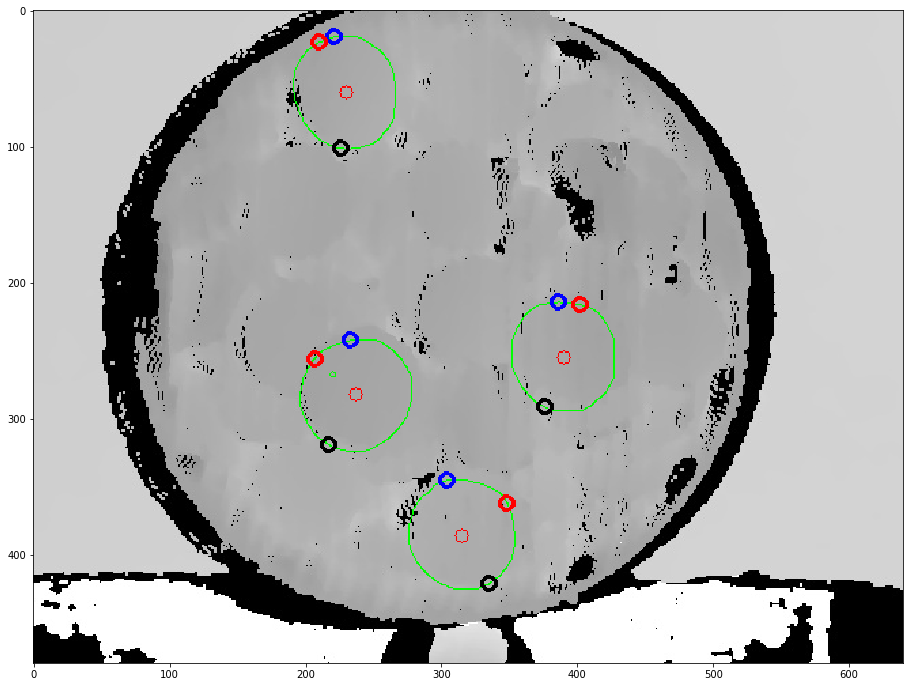

In [16]:
'''
################### Test selected stone pcd ######################
image = scipy.misc.imread("JPEGImages/2.jpeg")
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                    class_names, r['scores'])

#depth_image = cv2.imread("depth/"+img_index+".jpeg")
depth_image = cv2.imread("depth/2.jpeg") #83
depth_array = np.load("./depth/2.npy") #83

pose, depth_copy = generate_stone_pose(depth_image, depth_array, r)
'''

In [1]:
'''
################ Test all stones pcd + multiple stones pcd ##################

import open3d as o3d

image = scipy.misc.imread("JPEGImages/83.jpeg")
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                    class_names, r['scores'])

#depth_image = cv2.imread("depth/"+img_index+".jpeg")
depth_image = cv2.imread("depth/0.jpeg") #83
depth_array = np.load("./depth/0.npy") #83

depth_copy = depth_image.copy()
mask_size = []
points = []
point_show = []
points_ero = []
point_show_ero = []
mask_store = 5
window = 10
depth_intrin = [321.8862609863281, 238.18316650390625, 612.0938720703125, 611.785888671875]

point_all = []
for i in range(depth_copy.shape[0]):
    for j in range(depth_copy.shape[1]):
        if depth_array[i, j]/1000 < 0.2:
            xy = pixel_to_camera([j, i], depth_intrin, depth_array[i, j])
            point_all.append([xy[0], xy[1], depth_array[i, j]])

        
# Rank masks by footprints
for m in range(r['masks'].shape[2]):
    mask = r['masks'][:,:,m]
    #print(mask.shape)
    mask = mask.astype(np.uint8)
    mask_size.append(np.sum(mask))
mask_index = np.argsort(np.array(mask_size))[-mask_store:r['masks'].shape[2]]
#print(np.argsort(np.array(mask_size)))
#print(np.argsort(np.array(mask_size))[-3:r['masks'].shape[2]])
mask_center = []
max_min_pair = []
dist_min = []
dist_max = []
count_m = 0
kernel = np.ones((15,15),np.uint8)

for m in mask_index:
    mask = r['masks'][:,:,m]
    mask = mask.astype(np.uint8)
    point = []
    for i in range(depth_copy.shape[0]): #480
        for j in range(depth_copy.shape[1]): #640
            if mask[i,j] == 1:
                xy = pixel_to_camera([j, i], depth_intrin, depth_array[i, j])
                point.append([xy[0], xy[1], depth_array[i, j]])
    point_show = point_show + point
    points.append(point)
    
    erosion = cv2.erode(mask,kernel,iterations = 3)
    plt.figure()
    plt.imshow(erosion)
    point_ero = []
    for i in range(depth_copy.shape[0]): #480
        for j in range(depth_copy.shape[1]): #640
            if erosion[i, j] == 1:
                xy = pixel_to_camera([j, i], depth_intrin, depth_array[i, j])
                point_ero.append([xy[0], xy[1], depth_array[i, j]])
    point_show_ero = point_show_ero + point_ero
    points_ero.append(point_ero)

pcd_all = o3d.geometry.PointCloud()
pcd_all.points = o3d.utility.Vector3dVector(point_all)
o3d.io.write_point_cloud("test_ros_all.ply", pcd_all)
    
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[0])
o3d.io.write_point_cloud("test_ros.ply", pcd)

pcd_ero = o3d.geometry.PointCloud()
pcd_ero.points = o3d.utility.Vector3dVector(point_show_ero)
o3d.io.write_point_cloud("test_ros_ero_not_real.ply", pcd_ero)
'''

NameError: name 'scipy' is not defined

In [17]:
# Load saved point cloud and visualize it
pcd_load = o3d.io.read_point_cloud("test_ros_all.ply")
downpcd = o3d.geometry.voxel_down_sample(pcd_load, voxel_size=1)
o3d.visualization.draw_geometries([downpcd])

In [13]:

downpcd = o3d.geometry.voxel_down_sample(pcd, voxel_size=1)
#o3d.visualization.draw_geometries([downpcd])

print("Recompute the normal of the downsampled point cloud")
o3d.geometry.estimate_normals(downpcd, search_param=o3d.geometry.KDTreeSearchParamHybrid(
    radius=10, max_nn=30))
print("Normal as a numpy array")
print(np.asarray(downpcd.normals))
o3d.visualization.draw_geometries([downpcd])

Recompute the normal of the downsampled point cloud
Normal as a numpy array
[[ 0.16642745  0.96706349 -0.19258792]
 [ 0.22906704  0.80139325 -0.55253701]
 [ 0.10976135 -0.90657324  0.40752597]
 ...
 [ 0.15290032 -0.40931094 -0.8994921 ]
 [ 0.01275103  0.3766749   0.92625776]
 [ 0.07817349 -0.11989937 -0.98970351]]


In [16]:
#pcd_load = o3d.io.read_point_cloud("test_ros_ero_not_real.ply")
pcd_load = o3d.io.read_point_cloud("test_ros_ero.ply")
downpcd = o3d.geometry.voxel_down_sample(pcd_load, voxel_size=1)

color = np.array([1,0,0])
color = np.tile(color, (67, 1)) # 67 is number of points
downpcd.colors = o3d.utility.Vector3dVector(color)
#o3d.visualization.draw_geometries([downpcd])

print("Recompute the normal of the downsampled point cloud")
o3d.geometry.estimate_normals(downpcd, search_param=o3d.geometry.KDTreeSearchParamHybrid(
    radius=10, max_nn=30))
print("Normal as a numpy array")

for i in range(np.asarray(downpcd.normals).shape[0]):
    if downpcd.normals[i][2] > 0:
        downpcd.normals[i][0] = -downpcd.normals[i][0]
        downpcd.normals[i][1] = -downpcd.normals[i][1]
        downpcd.normals[i][2] = -downpcd.normals[i][2]
    downpcd.normals[i] = 3 * downpcd.normals[i]

normals = np.asarray(downpcd.normals)
#normals = normals / np.linalg.norm(normals)
surf_normal = np.sum(normals, axis=0) / normals.shape[0]
print(normals)
print(normals.shape)
print(surf_normal)
o3d.visualization.draw_geometries([downpcd])

Recompute the normal of the downsampled point cloud
Normal as a numpy array
[[ 0.82365941  1.07774559 -2.6758269 ]
 [ 1.04795013  1.21778548 -2.53353489]
 [ 0.63408422  1.22011153 -2.66632051]
 ...
 [-0.2365967  -0.06041974 -2.99004539]
 [-0.296855    0.08520233 -2.9840606 ]
 [-2.75814272  0.57773664 -1.02901365]]
(591, 3)
[-0.30274539  0.59489355 -2.57940193]


/home/zhekai/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/zhekai/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Processing 1 images
image                    shape: (480, 640, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  130.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


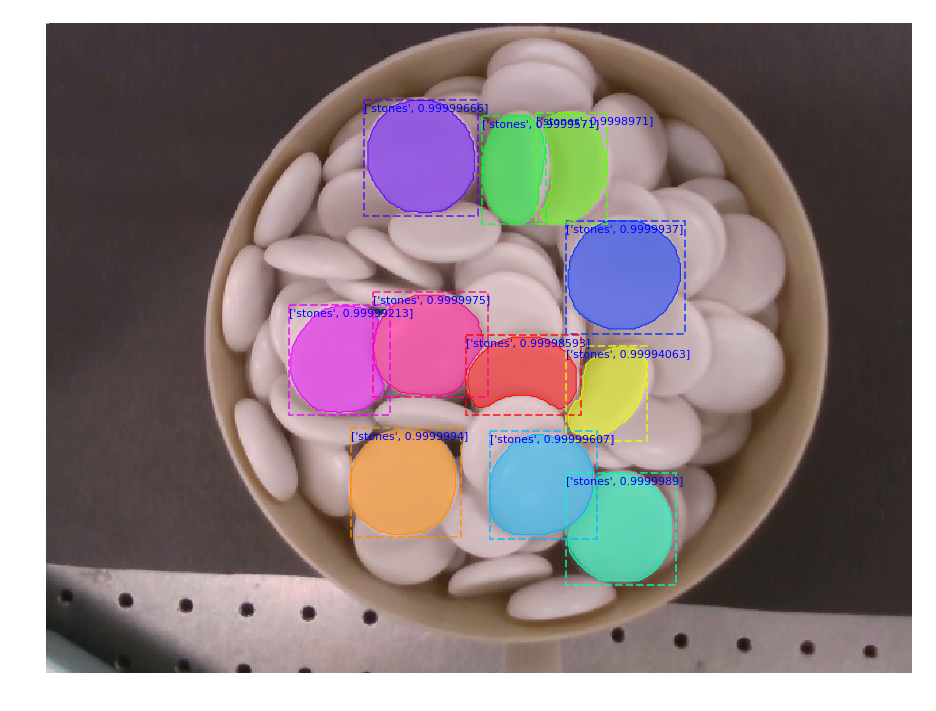

mask center [263, 339]
mask center [425, 374]
mask center [282, 237]
mask center [277, 99]
mask center [365, 341]
mask center [427, 185]
mask center [215, 249]
mask center [352, 259]
mask center [346, 106]
mask center [415, 272]
mask center [388, 107]
[0.9999994  0.9999989  0.9999975  0.99999666 0.99999607 0.9999937
 0.99999213 0.99998593 0.9999571  0.99994063 0.9998971 ]
[[263, 339, 0, 114.23659658795863], [425, 374, 1, 170.23806859806652], [282, 237, 2, 38.118237105091836], [277, 99, 3, 147.41099009232656], [365, 341, 4, 110.57124400132251], [427, 185, 5, 120.30793822520607], [215, 249, 6, 105.38500842150178], [352, 259, 7, 37.21558813185679], [346, 106, 8, 136.49908424601244], [415, 272, 9, 100.24470060806208], [388, 107, 10, 149.37536610833797]]
[[352, 259, 7, 37.21558813185679], [282, 237, 2, 38.118237105091836], [415, 272, 9, 100.24470060806208], [215, 249, 6, 105.38500842150178], [365, 341, 4, 110.57124400132251], [263, 339, 0, 114.23659658795863], [427, 185, 5, 120.307938225206

In [24]:
##########################TEST FOR WINDOW 9#############################
import open3d as o3d

image = scipy.misc.imread("JPEGImages/83.jpeg")
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                    class_names, r['scores'])

#depth_image = cv2.imread("depth/"+img_index+".jpeg")
depth_image = cv2.imread("depth/0.jpeg") #83
depth_array = np.load("./depth/0.npy") #83

depth_copy = depth_image.copy()
mask_size = []
points = []
point_show = []
points_ero = []
point_show_ero = []
mask_center = []
mask_store = 5
window = 10
depth_intrin = [321.8862609863281, 238.18316650390625, 612.0938720703125, 611.785888671875]
image_center = [depth_copy.shape[1]/2, depth_copy.shape[0]/2]

for m in range(r['masks'].shape[2]):
    overall_mask_x = []
    overall_mask_y = []

    mask = r['masks'][:,:,m]
    mask = mask.astype(np.uint8)
    edges = cv2.Canny(mask,0,1)
    for i in range(depth_copy.shape[0]): #480
        for j in range(depth_copy.shape[1]): #640
            if edges[i,j] == 255:
                overall_mask_x.append(j) #in pixel
                overall_mask_y.append(i) #in pixel
    mask_center.append([int(round(np.mean(overall_mask_x))), int(round(np.mean(overall_mask_y))), m]) #in pixel frame
    print('mask center', mask_center[m][:2])
    mask_center[m].append(np.linalg.norm(np.array(mask_center[m][:2])-np.array(image_center)))
print(r['scores'])
print(mask_center)
mask_center.sort(key=sortFourth)
print(mask_center)

In [7]:
depth_image = cv2.imread('./depth/0.jpeg', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
#depth_image = cv2.imread('./depth/0.jpeg')
depth_array = np.array(depth_image, dtype=np.float32)
print(depth_array.shape)
print(depth_array[36,532])
data = np.load('./depth/0.npy')
print(data[36,532])
print(data)

(480, 640)
207.0
207.0
[[206. 206. 206. ... 208. 208. 208.]
 [206. 206. 206. ... 208. 208. 208.]
 [206. 206. 206. ... 208. 208. 208.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [20]:
a = np.array([[1,2,3], [4,5,6]])
print(a)

np.sum(a,axis=0)

[[1 2 3]
 [4 5 6]]


array([5, 7, 9])

In [8]:
mask = r['masks'][:,:,mask_index[1]]
mask = mask.astype(np.uint8)
plt.figure()
#plt.rcParams['figure.figsize'] = [24, 12]
plt.imshow(mask)

kernel = np.ones((10,10),np.uint8)
erosion = cv2.erode(mask,kernel,iterations = 2)
print(erosion)

#scipy.ndimage.binary_erosion(mask, structure=np.ones((5,5))).astype(a.dtype)
plt.figure()
#plt.rcParams['figure.figsize'] = [24, 12]
plt.imshow(erosion)

NameError: name 'r' is not defined

Frames Captured
0.4000000059604645


(array([[[146, 255, 108],
         [146, 255, 108],
         [158, 255,  96],
         ...,
         [217, 255,  37],
         [217, 255,  37],
         [230, 255,  24]],
 
        [[146, 255, 108],
         [146, 255, 108],
         [158, 255,  96],
         ...,
         [217, 255,  37],
         [217, 255,  37],
         [230, 255,  24]],
 
        [[146, 255, 108],
         [146, 255, 108],
         [146, 255, 108],
         ...,
         [200, 255,  54],
         [200, 255,  54],
         [217, 255,  37]],
 
        ...,
 
        [[ 71, 255, 183],
         [ 71, 255, 183],
         [123, 255, 131],
         ...,
         [255,  98,   0],
         [255,  98,   0],
         [255,  98,   0]],
 
        [[ 71, 255, 183],
         [ 71, 255, 183],
         [255,  21,   0],
         ...,
         [255,  98,   0],
         [255,  98,   0],
         [255,  98,   0]],
 
        [[ 71, 255, 183],
         [ 71, 255, 183],
         [255,  21,   0],
         ...,
         [255,  98,   0],
  

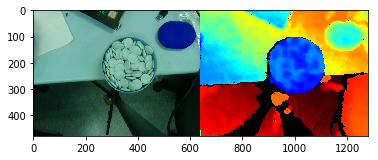

In [5]:
image_process("100")

In [7]:
def sortSecond(val): 
    return val[1]  
AA = [[1,5,4], [2,3,3], [3,1,1]]
AA.sort(key=sortSecond)
print(AA)

[[3, 1, 1], [2, 3, 3], [1, 5, 4]]


In [9]:
AA[0].append(1)
print(AA)

[[3, 1, 1, 1, 1], [2, 3, 3], [1, 5, 4]]


In [15]:
AA = [313, 96]- [640, 480]
print(AA)
np.linalg.norm(AA)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [17]:
AA = np.zeros(3)
AA[0] += 1
print(AA)

[1. 0. 0.]


In [33]:
avg = np.zeros(5)
avg += np.array([12,11,14,13,15])
print(avg)
print(avg.argsort())
sort_avg = avg[avg.argsort()]
print(sort_avg)

[12. 11. 14. 13. 15.]
[1 0 3 2 4]
[11. 12. 13. 14. 15.]
[1.2 1.1 1.4 1.3 1.5]


In [37]:
math.atan2(-1,-1)

-2.356194490192345

In [29]:
o3d.__version__

'0.7.0.0'